# POD 2 Spatial Dimensions

In [1]:
import numpy as np
import math as m
from scipy import linalg
from scipy.sparse import diags
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

Consider the following Advection-Diffusion System:
<br>
<br>
$$\frac{\partial}{\partial t} y(x_1,x_2,t) - \alpha (\frac{\partial^2}{\partial x_1^2} y(x_1,x_2,t) + \frac{\partial^2}{\partial x_2^2} y(x_1,x_2,t)) + \beta \frac{\partial}{\partial x_1} y(x_1,x_2,t) = 0, \quad (x_1,x_2) \in (0,1)^2, \quad t \in (0, T)$$
<br>
With the following boundary conditions:
<br>
<br>
$$y(0,x_2,t) = y(1,x_2,t)$$
$$\frac{\partial}{\partial x_1}y(0,x_2,t) = \frac{\partial}{\partial x_1}y(1,x_2,t)$$
$$y(x_1,0,t) = y(x_1,1,t)=0$$
$$y(x_1,x_2,0) = y_0(x_1, x_2)$$
<br>
Again we will discretize using Finite Differences and the Backward Euler Method. Set the parameters as the following:
<br>
<br>
$$\alpha = 0.01, \quad \beta = 1, \quad T = 0.5$$
$$n_1=n_2=30 \quad (h_1 = 1/30, h_2 = 1/31)$$
<br>
Where $n_1$ is the number of subintervals in the $x_1$ direction, and $n_2$ is the number of subintervals in the $x_2$ direction.

In [2]:
ALPHA = .01
BETA = 1.0
T_INT = .5
N1 = 30
N2 = 30
H1 = 1.0/N1
H2 = (1.0/(N2+1)) 
DELTA_T = .01
nt = int(T_INT/DELTA_T)
k = 10

Upwind FD gives:
<br>
<br>
$$\frac{d}{dt}y_{i,j}(t) - \alpha \frac{y_{i-1,j}(t)-2y_{i,j}(t)+y_{i+1,j}(t)}{h_1^2} - \alpha \frac{y_{i,j-1}(t)-2y_{i,j}(t)+y_{i,j+1}(t)}{h_2^2} + \beta \frac{y_{i,j}(t)-y_{i-1,j}(t)}{h_1} = 0$$ 
$$i = 1, \dots, n_1, \quad j=1, \dots,n_2$$
<br>
We can express this as a Kronecker product of two discretization matrices corresponding to each spatial dimension:
<br>
<br>
$$ A_1 = \frac{1}{h_1^2}
\begin{bmatrix}
-2\alpha - \beta h_1 & \alpha & & & \alpha + \beta h_1 \\
\alpha + \beta h_1 & -2\alpha -\beta h_1 & \alpha \\
& \ddots & \ddots & \ddots \\
& & \alpha + \beta h_1 & -2\alpha -\beta h_1 & \alpha\\
\alpha & & & \alpha + \beta h_1 & -2 \alpha - \beta h_1\\
\end{bmatrix} \in \mathbb{R} ^{n_1 \times n_1}$$

$$ A_2 = \frac{1}{h_2^2}
\begin{bmatrix}
-2\alpha & \alpha & & &\\
\alpha & -2\alpha & \alpha  & &\\
& \ddots & \ddots & \ddots &\\
& & \alpha & -2\alpha& \alpha\\
& & & \alpha & -2 \alpha \\
\end{bmatrix} \in \mathbb{R} ^{n_2 \times n_2}$$

<br>
The final discretization matrix is given by: 
<br>
<br>
$$A = I_{n_2} \otimes A_1 + A_2 \otimes I_{n_1} \in \mathbb{R}^{n_1 n_2 \times n_1 n_2}$$
<br> 
Notice that the size of $A$ is very large, and in this example is $900 \times 900$.

In [3]:
#Build A1
main_diag1 = [-2*ALPHA -BETA*H1 for dummy in range(N1)]
lower_diag1 = [ALPHA + BETA*H1 for dummy in range(N1)]
upper_diag1 = [ALPHA for dummy in range(N1)]
A1 = diags([main_diag1,lower_diag1,upper_diag1],[0,-1,1]).toarray()

A1[0][N1-1] = ALPHA + BETA * H1
A1[N1-1][0] = ALPHA

A1 *= 1/(H1**2)

#Build A2
main_diag2 = [-2*ALPHA for dummy in range(N2)]
outside_diag2 = [ALPHA for dummy in range(N2)]
A2 = diags([main_diag2,outside_diag2,outside_diag2],[0,-1,1]).toarray()

A2 *= (1/(H2 ** 2))

#Compute A

I1 = np.eye(N1)
I2 = np.eye(N2)

A = (np.kron(I2, A1) + np.kron(A2, I1))

Using Euler's Method and 50 time subintervals ($.01 = \delta t$), we get:
<br>
<br>
$$\frac{1}{\Delta t}(y_{j+1} - y_j) = A y_{j+1}$$
$$j = 0, \dots, n_t - 1$$

In [4]:
#Set up time and x-dimensions
time = np.arange(0, T_INT, DELTA_T)
x1 = np.arange(0, 1+(H1/2), H1)
x2 = np.arange(0, 1+(H2/2), H2)

Rearranging gives:
<br>
<br>
$$(I - \Delta t A)y_{j+1} = y_j$$
$$j=0, \dots , n_t - 1$$
<br>
We can now solve since we have an equation of $y_j$ in terms of $y_{j+1}$.
The following code solves this system with initial condition:
<br>
<br>
$$y_0(x_1,x_2) = e^{-100(x_1 - 0.5)^2 -100(x_2-0.5)^2}$$

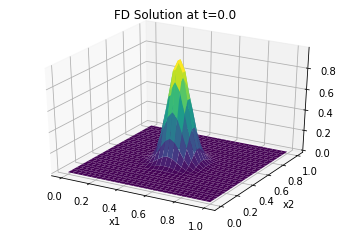

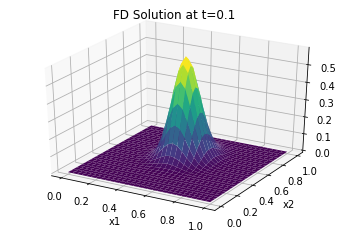

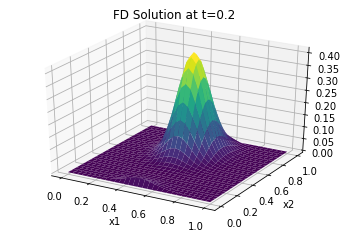

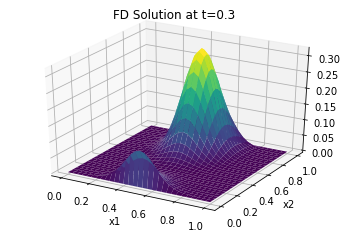

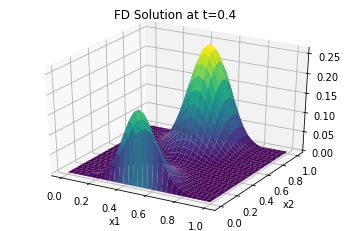

In [5]:
#Create initial condition matrix
y0 = np.zeros((N1 + 1, N2 + 2))
for i in range(N2 + 2):
    y0[:,i] = np.exp(-100*np.power((x1-.5),2) -100*(x2[i] -.5)**2)

y0 = y0[1:,1:N2+1]

#Backwards Euler Method
I = np.eye(np.shape(A)[0])
S = np.zeros((N1*N2,nt + 1))
S[:,0] = np.reshape(y0,(N1*N2))

for i_t in range(nt):
    S[:, i_t + 1] = linalg.solve((I-DELTA_T*A),S[:,i_t])


#Plots solution at 5 various snapshots in time on the time interval (0, .5)
for snap in np.arange(0,nt,10):
    fig = plt.figure()
    yplot = np.zeros((N1+1,N2+2))
    yplot[1:,1:N2+1] = np.reshape(S[:,snap],(N1,N2))
    
    yplot[0,:]= yplot[N1,:]
    [X1,X2]= np.meshgrid(x1,x2)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X1, X2, np.transpose(yplot), rstride=1, cstride=1,cmap='viridis',edgecolor='none')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'FD Solution at t={snap/100.0}')
    plt.show()

Now we approximate using the POD method.
<br>
First we adjust by the mean:

In [6]:
#Adjust S by its mean
ymean = np.mean(S, 1)
ymean = np.reshape(ymean,(900,1))
ej=np.ones((1,nt+1))
S -= ymean @ ej

Then compute the SVD of S

In [7]:
U, G, V = linalg.svd(S, full_matrices = True)
Uk = U[: , 0:k]
Ak = np.transpose(Uk) @ A @ Uk

Populate the matrices needed to solve:
<br>
<br>
$$\frac{1}{\Delta t}(\widehat{y}_{j+1} - \widehat{y}_j) = U_k^T A U_k \widehat{y}_{j+1} + U_k^T A \bar{y}$$

In [8]:
Ik = np.eye(k)
Sk = np.zeros((k, nt +1))
y0k = np.transpose(Uk) @ (np.reshape(y0, (900,1)) - ymean)
y0k = np.reshape(y0k,(10,))
yAk = np.transpose(Uk) @ (A @ ymean)
yAk = np.reshape(yAk,(10,))
Sk[: ,0] = y0k

Now we can use the backward Euler Method to solve the above:

In [9]:
#Backward Euler Method to solve
for it in range(nt):
    Sk[: , it+1] = linalg.solve((Ik-DELTA_T*Ak),(Sk[: , it] + DELTA_T* yAk ))

Last step: Add the mean back in and plot everything!

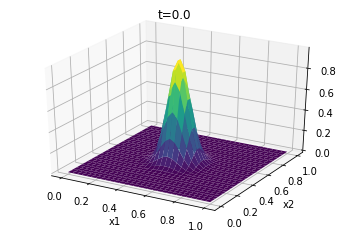

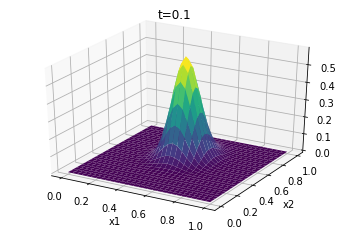

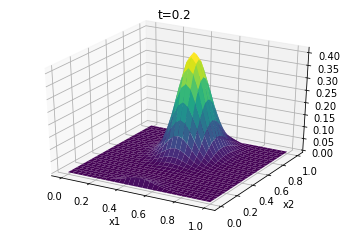

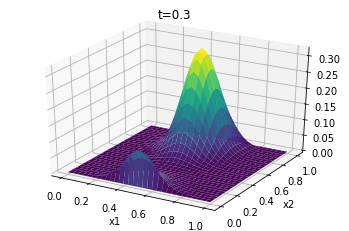

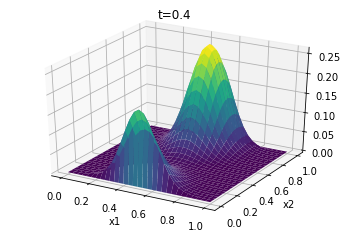

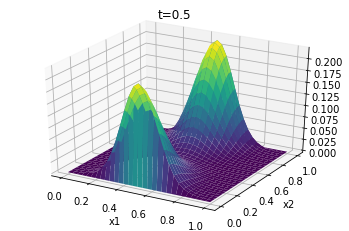

In [10]:
#Add mean
S += ymean @ np.ones((1,nt+1))

#Plot:)
for it in np.arange(0,nt+1,10):
    fig = plt.figure() 
    yPOD = Uk @ np.reshape(Sk[: , it],(10,1)) + ymean
    yplot = np.zeros((N1+1,N2+2))
    yplot[1:N1+1,1:N2+1] = np.reshape(yPOD,(N1 ,N2))
    yplot[0 ,:] = yplot[N1,:]
    
    [X1,X2]= np.meshgrid(x1,x2)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X1, X2, np.transpose(yplot), rstride=1, cstride=1,cmap='viridis',edgecolor='none')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f't={it/100}')
    plt.show()